In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


C:\Users\abhir\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape : {x_train.shape} - y_train shape : {y_train.shape}")
print(f"x_test shape : {x_test.shape} - y_test shape : {y_test.shape}")


x_train shape : (50000, 32, 32, 3) - y_train shape : (50000, 1)
x_test shape : (10000, 32, 32, 3) - y_test shape : (10000, 1)


In [3]:
x_train = x_train[:500]
y_train = y_train[:500]
x_test = x_test[:500]
y_test = y_test[:500]


In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 40
image_size = 72 # We'll resize input images to this size.
patch_size = 6
num_patches = (image_size//patch_size)**2
num_heads = 4
projection_dim = 64
transformer_units = [
    projection_dim*2,
    projection_dim
] # Size of the transformer layers.
transformer_layers = 8
mlp_head_units = [2048, 1024] # Size of the dense layers of the final classifier.

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        )
    ],
    name="data_augmentation"
)
data_augmentation.layers[0].adapt(x_train)

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = "VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image Size : 72 X 72
Patch Size : 6 X 6
Patches per Image : 144
Elements per Patch : 108


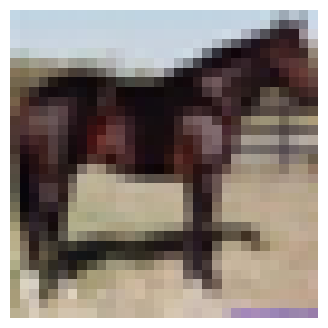

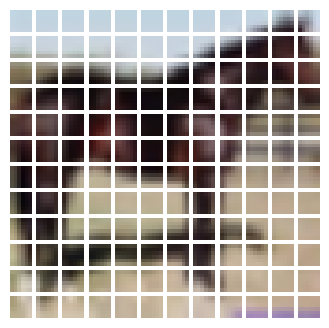

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image Size : {image_size} X {image_size}")
print(f"Patch Size : {patch_size} X {patch_size}")
print(f"Patches per Image : {patches.shape[1]}")
print(f"Elements per Patch : {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i+1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim = num_patches,
            output_dim = projection_dim
        )
        
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch)+self.position_embedding(positions)
        return encoded
    

In [10]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment Data.
    augmented = data_augmentation(inputs)
    # Create Patches.
    patches = Patches(patch_size)(augmented)
    # Encode Patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    # Create multiple layers of the Transformer Block.
    for _ in range(transformer_layers):
        # Layer Normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim,
            dropout=0.1
        )(x1, x1)
        # Skip Connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        #Layer Normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip Connection 2.
        encoded_patches = layers.Add()([x3, x2])
        
    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify Outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras Model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [11]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
        ]
    )
    
    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only = True,
        save_weights_only = True
    )
    
    history = model.fit(
        x = x_train,
        y = y_train,
        batch_size = batch_size,
        epochs = num_epochs,
        validation_split=0.1,
        callbacks = [checkpoint_callback]
    )
    
    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test Accuracy : {round(accuracy*100, 2)}%")
    print(f"Test Top 5 Accuracy : {round(top_5_accuracy*100, 2)}%")
    

In [12]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/40
2/2 [==============================] - 23s 9s/step - loss: 6.1095 - accuracy: 0.1044 - top-5-accuracy: 0.5422 - val_loss: 4.4147 - val_accuracy: 0.1800 - val_top-5-accuracy: 0.7000
Epoch 2/40
2/2 [==============================] - 11s 5s/step - loss: 5.3466 - accuracy: 0.1711 - top-5-accuracy: 0.6311 - val_loss: 3.9527 - val_accuracy: 0.1800 - val_top-5-accuracy: 0.5800
Epoch 3/40
2/2 [==============================] - 11s 5s/step - loss: 4.1971 - accuracy: 0.1756 - top-5-accuracy: 0.6644 - val_loss: 2.3698 - val_accuracy: 0.1600 - val_top-5-accuracy: 0.7000
Epoch 4/40
2/2 [==============================] - 12s 6s/step - loss: 3.0261 - accuracy: 0.2400 - top-5-accuracy: 0.6978 - val_loss: 2.1615 - val_accuracy: 0.2200 - val_top-5-accuracy: 0.7000
Epoch 5/40
2/2 [==============================] - 11s 5s/step - loss: 2.5064 - accuracy: 0.2933 - top-5-accuracy: 0.7267 - val_loss: 2.1497 - val_accuracy: 0.1600 - val_top-5-accuracy: 0.7200
Epoch 6/40
2/2 [========================

In [18]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'car',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [19]:
def img_predict(images, model):
    if len(images.shape)==3:
        out = model.predict(images.reshape(-1, *images.shape))
    else:
        out = model.predict(images)
    prediction = np.argmax(out, axis=1)
    img_prediction = [class_names[i] for i in prediction]
    return img_prediction

1/1 [==============================] - 0s 36ms/step
['airplane']


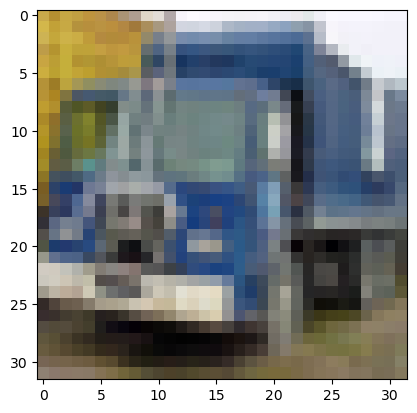

In [20]:
index = 14
plt.imshow(x_test[index])
prediction = img_predict(x_test[index], vit_classifier)
print(prediction)